# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Reduce Memory
#Ref : https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

In [78]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [79]:
def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True,sep=';')
    df = reduce_mem_usage(df)
    return df

In [80]:
azdias = import_data('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Memory usage of dataframe is 2488.61 MB
Memory usage after optimization is: 542.46 MB
Decreased by 78.2%


In [81]:
customers = import_data('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Memory usage of dataframe is 539.55 MB
Memory usage after optimization is: 117.26 MB
Decreased by 78.3%


In [12]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [7]:
azdias.shape

(891221, 366)

In [8]:
customers.shape

(191652, 369)

In [9]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [10]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [2]:
data_info= pd.read_excel('DIAS Attributes - Values 2017.xlsx',index_col=0)

In [3]:
data_info.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


In [4]:
sum_info= pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx',index_col=0)

In [5]:
sum_info.head()

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [82]:
data_info['Attribute']=data_info['Attribute'].fillna(method='ffill')

In [83]:
data_info.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,NaN,0,no classification possible
NaN,AGER_TYP,NaN,1,passive elderly
NaN,AGER_TYP,NaN,2,cultural elderly
NaN,AGER_TYP,NaN,3,experience-driven elderly


In [84]:
data_info.Meaning.value_counts()

unknown                                                                                            232
average                                                                                            162
high                                                                                               154
low                                                                                                154
very high                                                                                          142
very low                                                                                           139
none                                                                                               138
Prospects > 24 months                                                                               34
Singlebuyer 13-24 months                                                                            34
Multibuyer 0-12 months                                                   

In [85]:
# unknown ,no transaction known , no transactions known 
feat_info = data_info[(data_info['Meaning'].str.contains("unknown") | data_info['Meaning'].str.contains("no "))]

In [86]:
feat_info.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,NaN,0,no classification possible
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
NaN,ANREDE_KZ,gender,"-1, 0",unknown


In [87]:
# Convert the value column to be a list of strings
feat_info.loc[feat_info['Attribute'] == 'AGER_TYP', 'Value'].astype(str).str.cat(sep=',').split(',')

['-1', '0']

In [88]:
# Because both of the first 2 rows of feat_info belong to the same attribute, combine the values 
# for each row into a single list of strings

unknowns = []
for attribute in feat_info['Attribute'].unique():
    _ = feat_info.loc[feat_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    unknowns.append(_)
    
unknowns = pd.concat([pd.Series(feat_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['attribute', 'missing_or_unknown']
unknowns

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,"[-1, 0]"
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEUINTL_2015,[-1]
8,CJT_GESAMTTYP,[0]
9,D19_BANKEN_ANZ_12,[0]


In [23]:
# Using the unknown dataframe, identify missing or unknown data values and convert them to NaNs.
import time
start = time.time()
    
for row in unknowns['attribute']:
    print(row)
    if row in azdias.columns:
        na_map = unknowns.loc[unknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
        na_idx = azdias.loc[:, row].isin(na_map)
        azdias.loc[na_idx, row] = np.NaN
    else:
        continue

end = time.time()
elapsed = end - start
elapsed

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_RES

20.526632070541382

In [24]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [26]:
frame={'x':azdias.isnull().mean()}

In [27]:
result = pd.DataFrame(frame)

In [29]:
result=result.reset_index()

In [31]:
result=result.rename(columns={'index':'Attribute','x':'na_rate'}).sort_values('na_rate',ascending=False)

In [32]:
result.head()

,Attribute,na_rate
7,ALTER_KIND4,0.998648
349,TITEL_KZ,0.997576
6,ALTER_KIND3,0.993077
76,D19_TELKO_ONLINE_DATUM,0.990796
34,D19_BANKEN_OFFLINE_DATUM,0.977911


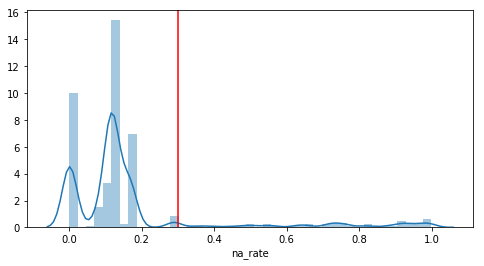

In [34]:
f,ax = plt.subplots(figsize=(8,4))
sns.distplot(result['na_rate'],ax=ax)
plt.axvline(0.3,color='r')

In [35]:
drop_cols = result[result['na_rate']>0.3]['Attribute'].tolist() 

In [69]:
drop_cols

['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'D19_TELKO_ONLINE_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'ALTER_KIND2',
 'D19_TELKO_ANZ_12',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_VERSI_ANZ_12',
 'D19_TELKO_OFFLINE_DATUM',
 'ALTER_KIND1',
 'D19_BANKEN_ANZ_24',
 'D19_VERSI_ANZ_24',
 'KBA05_ANTG4',
 'D19_BANKEN_ONLINE_DATUM',
 'AGER_TYP',
 'D19_BANKEN_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_TELKO_DATUM',
 'EXTSEL992',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'KBA05_ANTG3',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_GESAMT_ANZ_12',
 'KK_KUNDENTYP',
 'D19_VERSAND_ANZ_24',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ANZ_24',
 'D19_VERSAND_ONLINE_DATUM',
 'KBA05_BAUMAX',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'KBA05_ANTG2',
 'KBA05_ANTG1',
 'D19_GESAMT_DATUM',
 'KBA05_MAXVORB',
 'ALTER_HH']

In [37]:
azdias.shape

(891221, 366)

In [40]:
azdias.drop(drop_cols,axis=1,inplace=True)

In [41]:
azdias.shape

(891221, 326)

In [42]:
# Null in rows

In [43]:
s1 = azdias.isnull().sum(axis=1).sort_values(ascending=False)

In [45]:
s1.describe()

count    891221.000000
mean         32.093779
std          73.337133
min           0.000000
25%           0.000000
50%           1.000000
75%           7.000000
max         246.000000
dtype: float64

Text(0.5,1,'Distribution of Null Count for rows')

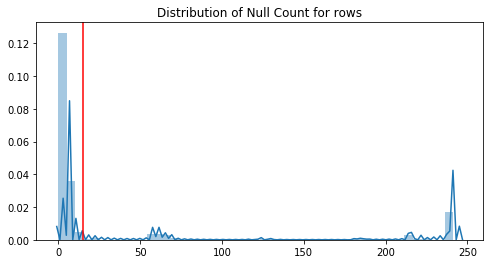

In [49]:
f,ax = plt.subplots(figsize=(8,4))
sns.distplot(s1,ax=ax)
plt.axvline(15,color='r')
plt.title('Distribution of Null Count for rows')

In [51]:
azdias['drop_rows'] = azdias.isnull().sum(axis=1).apply(lambda x:1 if x>15 else 0)

In [52]:
azdias = azdias[azdias['drop_rows']==0]

In [54]:
azdias.drop('drop_rows',axis=1,inplace=True)

In [55]:
azdias.shape

(732440, 326)

In [58]:
azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0


In [56]:
categorical = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP']

In [57]:

# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# For every column which is encoded as "categorical" in the feat_info dataset
# print the value counts
        
for i in categorical:
    if i in azdias.columns:
        print(azdias[i].value_counts())

2.0    381832
1.0    350608
Name: ANREDE_KZ, dtype: int64
6B    53643
8A    50496
4C    43672
2D    32660
7A    32412
3C    32328
3D    31944
8B    31077
4A    30038
8C    29976
9D    26585
9B    25759
9C    22787
7B    22783
9A    19945
2C    17619
8D    16583
6E    15488
5D    13977
2B    13946
6C    13788
2A    11820
1D    11382
1A    10099
5A     9658
5B     9624
5C     8989
4B     8232
7C     8084
4D     8008
6A     6376
3A     5823
6D     5724
3B     5669
6F     5028
4E     4978
1E     4757
7D     4403
7E     4348
1C     3990
5F     3912
9E     3824
1B     3791
5E     3227
XX      282
Name: CAMEO_DEU_2015, dtype: int64
4.0    182214
3.0    135116
2.0    133721
5.0    104644
6.0     92027
1.0     84718
Name: CJT_GESAMTTYP, dtype: int64
9.0    231238
1.0    103099
4.0     70051
6.0     49993
3.0     48831
2.0     44406
5.0     21892
Name: D19_KONSUMTYP, dtype: int64
6.0    277488
1.0    182235
5.0     97317
2.0     93585
4.0     52162
3.0     29653
Name: FINANZTYP, dtype: int64
1.0

In [59]:
# The only binary categorical variable that does not take 
# integer values is OST_WEST_KZ which uses either W or O
# will be re-encoded with 1 and 0.  Other binary categorical
# variables will be lest as is. 

azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].head()

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [60]:
 #If column has less than 10 levels, re-encode using dummy variables.
# If column has equal to or more than 10 different values, drop for
# simplicity. Make lists of these columns to be used below.

cat_cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']

cat_cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']

In [61]:
azdias.drop(cat_cols_to_drop, axis=1, inplace = True)
azdias.shape

(732440, 319)

In [62]:
# Create dummy variables for columns with less than 10 
# unique values then drop the original columns
for col in cat_cols_to_dummy:
    dummy = pd.get_dummies(azdias[col], prefix = col)
    azdias = pd.concat([azdias, dummy], axis = 1)

print(azdias.shape)

azdias.drop(cat_cols_to_dummy, axis=1, inplace = True)

azdias.shape

(732440, 382)


(732440, 369)

In [90]:
customers.shape

(191652, 369)

In [89]:
# View the first few lines of the customers dataframe
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [91]:
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [92]:
# Investigate the ONLINE_PURCHASE column
customers['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

In [93]:
#Investigate the PRODUCT_GROUP column
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [94]:
def clean_data(df1, df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        df1: Customer demographics DataFrame
        df2: Unknowns DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # convert missing value codes into NaNs, ...
    for row in df2['attribute']:
        if row in df1.columns:
            na_map = df2.loc[df2['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df1.loc[:, row].isin(na_map)
            df1.loc[na_idx, row] = np.NaN
        else:
            continue
            
    drop_cols=['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'D19_TELKO_ONLINE_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'ALTER_KIND2',
 'D19_TELKO_ANZ_12',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_VERSI_ANZ_12',
 'D19_TELKO_OFFLINE_DATUM',
 'ALTER_KIND1',
 'D19_BANKEN_ANZ_24',
 'D19_VERSI_ANZ_24',
 'KBA05_ANTG4',
 'D19_BANKEN_ONLINE_DATUM',
 'AGER_TYP',
 'D19_BANKEN_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_TELKO_DATUM',
 'EXTSEL992',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'KBA05_ANTG3',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_GESAMT_ANZ_12',
 'KK_KUNDENTYP',
 'D19_VERSAND_ANZ_24',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ANZ_24',
 'D19_VERSAND_ONLINE_DATUM',
 'KBA05_BAUMAX',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'KBA05_ANTG2',
 'KBA05_ANTG1',
 'D19_GESAMT_DATUM',
 'KBA05_MAXVORB',
 'ALTER_HH']
    df1.drop(drop_cols, axis=1, inplace = True)
    #df1['drop_rows'] = df1.isnull().sum(axis=1).apply(lambda x:1 if x>15 else 0)
    #df1 = df1[df1['drop_rows']==0]
    #df1.drop('drop_rows',axis=1,inplace=True)
    # select, re-encode, and engineer column values
    df1['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
    for col in cols_to_dummy:
        dummy = pd.get_dummies(df1[col], prefix = col)
        df1 = pd.concat([df1, dummy], axis = 1)
        
    df1.drop(cols_to_dummy, axis=1, inplace = True)
    cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']
    df1.drop(cols_to_drop, axis=1, inplace = True)
    
    return df1
    
    

In [95]:
# Run the clean_data function on the azdias dataset
customers = clean_data(customers, unknowns)

In [96]:
customers.shape

(191652, 371)

In [97]:

# Determine the columns that are in the cleaned customers dataframe
# but not the cleaned azdias dataframe (these 3 are expected)
customers.columns[~customers.columns.isin(azdias.columns)]

Index(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE',
       'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_3.0',
       'CJT_GESAMTTYP_4.0', 'CJT_GESAMTTYP_5.0', 'CJT_GESAMTTYP_6.0',
       'FINANZTYP_1.0', 'FINANZTYP_2.0', 'FINANZTYP_3.0', 'FINANZTYP_4.0',
       'FINANZTYP_5.0', 'FINANZTYP_6.0', 'GEBAEUDETYP_1.0', 'GEBAEUDETYP_2.0',
       'GEBAEUDETYP_3.0', 'GEBAEUDETYP_4.0', 'GEBAEUDETYP_6.0',
       'GEBAEUDETYP_8.0', 'GEBAEUDETYP_RASTER_1.0', 'GEBAEUDETYP_RASTER_2.0',
       'GEBAEUDETYP_RASTER_3.0', 'GEBAEUDETYP_RASTER_4.0',
       'GEBAEUDETYP_RASTER_5.0', 'HEALTH_TYP_1.0', 'HEALTH_TYP_2.0',
       'HEALTH_TYP_3.0', 'KBA05_HERSTTEMP_1.0', 'KBA05_HERSTTEMP_2.0',
       'KBA05_HERSTTEMP_3.0', 'KBA05_HERSTTEMP_4.0', 'KBA05_HERSTTEMP_5.0',
       'KBA05_MAXHERST_1.0', 'KBA05_MAXHERST_2.0', 'KBA05_MAXHERST_3.0',
       'KBA05_MAXHERST_4.0', 'KBA05_MAXHERST_5.0', 'KBA05_MODTEMP_1.0',
       'KBA05_MODTEMP_2.0', 'KBA05_MODTEMP_3.0', 'KBA05_MODTEMP_4.0',
       'KBA05

In [74]:

# Determine the columns that are in the cleaned azdias dataframe
# but not the cleaned customers dataframe
azdias.columns[~azdias.columns.isin(customers.columns)]

Index(['GEBAEUDETYP_5.0'], dtype='object')

In [75]:
# Find index of the GEBAEUDETYP_5.0 column in the azdias dataframe
column_index = azdias.columns.get_loc("GEBAEUDETYP_5.0")
column_index

322

In [76]:
# Insert a column called GEBAEUDETYP_5.0 at index = 315
# with all values = 0
customers.insert(loc=column_index, column='GEBAEUDETYP_5.0', value=0)

In [77]:
# Determine that the number of columns match for the dataframes (taking
# into accont the extra 3 columns)
customers.shape[1] == azdias.shape[1] + 3

True

In [79]:
azdias['CAMEO_DEUG_2015'].value_counts()

8      74361
6      57837
9      57157
4      54909
8.0    53771
2      44074
3      43865
6.0    42210
9.0    41743
7      41595
4.0    40019
2.0    31971
3.0    31899
7.0    30435
5      28794
5.0    20593
1      19714
1.0    14305
X        282
Name: CAMEO_DEUG_2015, dtype: int64

In [80]:

# The imputer does not work at this stage because the columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 
# have string values of "X" and "XX".  EINGEFUEGT_AM has a similar issue. Remove these columns 
# for simplicity.  
del azdias['CAMEO_DEUG_2015']
del azdias['CAMEO_INTL_2015']
del azdias['EINGEFUEGT_AM']
del customers['CAMEO_DEUG_2015']
del customers['CAMEO_INTL_2015']
del customers['EINGEFUEGT_AM']


In [81]:
azdias.shape, customers.shape

((732440, 366), (131219, 369))

In [98]:
# Make a new dataframe to hold the 3 extra columns of the customers dataset in case we need 
# them for later
customers_extra_cols = customers[['LNR','PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']]
customers_extra_cols.head()

,LNR,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,9626,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,9628,FOOD,SINGLE_BUYER,0
2,143872,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,143873,COSMETIC,MULTI_BUYER,0
4,143874,FOOD,MULTI_BUYER,0


In [84]:
# Delete the 3 extra columns from the customers dataframe so it has the same columns
# as the azdias dataframe
del customers['PRODUCT_GROUP']
del customers['CUSTOMER_GROUP']
del customers['ONLINE_PURCHASE']
customers.shape

(131219, 366)

In [86]:
# Impute the missing values using the mean
from sklearn.preprocessing import Imputer, StandardScaler
imputer = Imputer()
azdias_clean = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)


ValueError: could not convert string to float: 'D19_UNBEKANNT'

In [96]:
azdias.isnull().sum().sort_values(ascending=False)

ALTERSKATEGORIE_FEIN           166715
D19_KONSUMTYP                  162930
D19_TELKO_ONLINE_QUOTE_12      162930
D19_SOZIALES                   162930
D19_LETZTER_KAUF_BRANCHE       162930
D19_VERSI_ONLINE_QUOTE_12      162930
D19_LOTTO                      162930
W_KEIT_KIND_HH                  53913
REGIOTYP                        40606
KKK                             40606
HH_DELTA_FLAG                   30297
VHN                              7080
RELAT_AB                         3759
ORTSGR_KLS9                      3679
ARBEIT                           3679
STRUKTURTYP                      3679
VERDICHTUNGSRAUM                 3679
GEMEINDETYP                      3679
PLZ8_HHZ                         3297
PLZ8_GBZ                         3297
PLZ8_BAUMAX                      3297
PLZ8_ANTG4                       3297
PLZ8_ANTG3                       3297
PLZ8_ANTG2                       3297
PLZ8_ANTG1                       3297
ANZ_HH_TITEL                     3292
UMFELD_ALT  

In [99]:
azdias['D19_LETZTER_KAUF_BRANCHE'].value_counts()

D19_UNBEKANNT             178160
D19_VERSICHERUNGEN         51847
D19_SONSTIGE               40282
D19_VOLLSORTIMENT          31094
D19_SCHUHE                 28303
D19_BUCH_CD                25461
D19_VERSAND_REST           23243
D19_DROGERIEARTIKEL        21232
D19_BANKEN_DIREKT          20831
D19_BEKLEIDUNG_REST        19023
D19_HAUS_DEKO              18686
D19_TELKO_MOBILE           13069
D19_ENERGIE                11076
D19_TELKO_REST             10361
D19_BANKEN_GROSS            9477
D19_BEKLEIDUNG_GEH          9094
D19_KINDERARTIKEL           6375
D19_FREIZEIT                6355
D19_TECHNIK                 6244
D19_LEBENSMITTEL            5764
D19_BANKEN_REST             4677
D19_RATGEBER                4458
D19_NAHRUNGSERGAENZUNG      3703
D19_DIGIT_SERV              3252
D19_REISEN                  2790
D19_TIERARTIKEL             2283
D19_SAMMELARTIKEL           2231
D19_HANDWERK                2016
D19_WEIN_FEINKOST           1955
D19_GARTEN                  1476
D19_BANKEN

In [101]:
azdias['D19_LOTTO'].value_counts()

0.0    437569
7.0    104770
6.0     23635
5.0      1753
3.0      1637
4.0        71
2.0        58
1.0        17
Name: D19_LOTTO, dtype: int64

In [103]:
azdias.drop(['D19_LETZTER_KAUF_BRANCHE','D19_LOTTO'],axis=1,inplace=True)

In [104]:
customers.drop(['D19_LETZTER_KAUF_BRANCHE','D19_LOTTO'],axis=1,inplace=True)

In [105]:
# Impute the missing values using the mean
from sklearn.preprocessing import Imputer, StandardScaler
imputer = Imputer()
azdias_clean = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)

In [106]:
customers_clean = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [108]:
scaler = StandardScaler()
azdias1= azdias_clean.copy()
azdias2 = scaler.fit_transform(azdias1)

final_azdias = pd.DataFrame(data=azdias2, index=azdias_clean.index, columns=azdias_clean.columns)
final_azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1.057824,1.259660,1.640855,0.186281,-0.125912,-0.298834,0.225714,0.334745,-0.060503,-0.179682,...,-0.408368,0.44202,-0.295946,-0.205912,-0.448799,-0.658734,-0.601416,1.891895,-0.907900,0.995154
1,1.057843,1.259660,0.747417,0.120125,-0.125912,-0.298834,-0.633709,-0.032349,-0.060503,-0.179682,...,-0.408368,0.44202,-0.295946,-0.205912,-0.448799,-0.658734,1.662743,-0.528571,1.101443,-1.004870
2,1.057847,-0.936021,-0.146022,-0.475279,-0.125912,-0.298834,-1.493132,-0.399444,-0.060503,-1.185459,...,-0.408368,0.44202,-0.295946,-0.205912,-0.448799,1.518064,-0.601416,-0.528571,1.101443,-1.004870
3,1.057905,-0.936021,0.077338,-0.342967,-0.125912,-0.298834,1.944561,-0.326025,-0.060503,0.826095,...,-0.408368,0.44202,-0.295946,-0.205912,-0.448799,-0.658734,1.662743,-0.528571,-0.907900,0.995154
4,1.057917,-0.936021,-0.816101,-0.210655,-0.125912,-0.298834,-0.633709,-0.399444,-0.060503,-1.185459,...,-0.408368,0.44202,-0.295946,-0.205912,2.228169,-0.658734,-0.601416,-0.528571,-0.907900,0.995154


In [110]:
customers1= customers_clean.copy()
customers2 = scaler.fit_transform(customers1)

final_customers = pd.DataFrame(data=customers2, index=customers_clean.index, columns=customers_clean.columns)
final_customers.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,-1.560171,-0.350447,-0.088765,-0.273450,-0.125793,-0.26573,-0.205233,-0.256976,-0.134612,-1.812384,...,1.269502,0.205382,-0.129431,-0.098859,-0.533005,-0.581542,-0.443677,1.376105,1.023278,-0.991085
1,0.864452,-0.350447,-2.547046,-0.273450,-0.125793,-0.26573,-0.919624,-0.256976,-0.134612,0.171087,...,1.269502,0.205382,-0.129431,-0.098859,-0.533005,1.719566,-0.443677,-0.726689,-0.977251,1.008995
2,0.864470,-0.350447,-0.580422,-0.345950,-0.048680,-0.26573,-1.634015,-0.256976,-0.134612,-1.812384,...,-0.787710,0.205382,-0.129431,-0.098859,1.876156,-0.581542,-0.443677,-0.726689,1.023278,-0.991085
3,0.864488,-0.350447,0.894547,0.161553,-0.125793,-0.26573,1.223550,0.184154,-0.134612,0.171087,...,-0.787710,0.205382,-0.129431,-0.098859,-0.533005,1.719566,-0.443677,-0.726689,-0.977251,1.008995
4,0.864741,-0.350447,-0.088765,-0.273450,-0.125793,-0.26573,-0.205233,-0.256976,-0.134612,0.171087,...,-0.787710,0.205382,-0.129431,-0.098859,-0.533005,1.719566,-0.443677,-0.726689,-0.977251,1.008995


In [112]:
# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.
import pickle
pickle.dump(final_azdias, open("final_azdias.pickle", "wb"))

# Dump the customers dataframe to a pickle object to use for later.
pickle.dump(final_customers, open("final_customers.pickle", "wb"))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.externals import joblib
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

from sklearn.preprocessing import Imputer, StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline


In [3]:
# Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
import pickle
azdias_final = pickle.load(open("final_azdias.pickle", "rb"))

# Reload cleaned customers object as saved after above analysis
customers_final = pickle.load(open("final_customers.pickle", "rb"))

In [4]:
%%time
pca = PCA().fit(azdias_final)

CPU times: user 6min 49s, sys: 33.7 s, total: 7min 22s
Wall time: 13min 30s


threshold_idx: 36


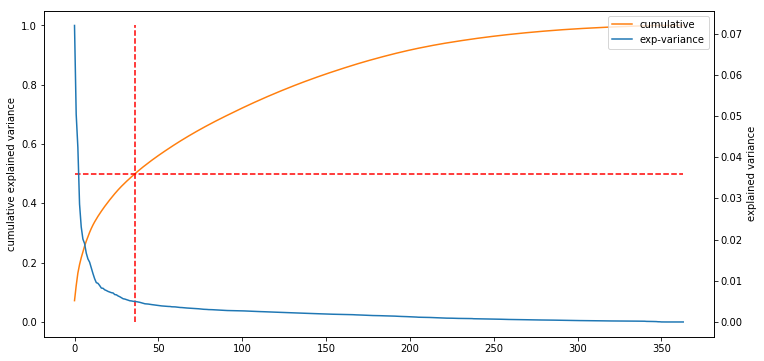

In [5]:
f,ax = plt.subplots(figsize=(12,6))
l0 = plt.plot(pca.explained_variance_ratio_.cumsum(),color=sns.color_palette()[1],label='cumulative')
plt.ylabel('cumulative explained variance')

threshold = .5
threshold_idx = np.argmin(np.abs(threshold - pca.explained_variance_ratio_.cumsum()))
print('threshold_idx:',threshold_idx)
h_line = np.ones(len(pca.explained_variance_ratio_))*threshold
y_vline = [0, 1]
x_vline = np.ones(len(y_vline))*threshold_idx
plt.plot(np.arange(len(pca.explained_variance_ratio_)), h_line, 'r--')
plt.plot(x_vline, y_vline, 'r--')

plt.twinx()
l1 = plt.plot(pca.explained_variance_ratio_,color=sns.color_palette()[0],label='exp-variance')

plt.xlabel('number of components')
plt.ylabel('explained variance')
lns = l0 + l1
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='best')

In [6]:

threshold_idx = np.argmin(np.abs(threshold - pca.explained_variance_ratio_.cumsum()))
threshold_idx

36

In [7]:
n_components = 36
pca10 = PCA(n_components = n_components,random_state=42)
azdias_scaled_pca = pca10.fit_transform(azdias_final)
pca10.components_.shape

(36, 364)

In [8]:

def pca_detail(pca,cols,idx=0,top_features=10):
    top_idx = np.argsort(-np.abs(pca.components_[idx]))[:top_features]
    x = cols[top_idx]
    y = pca.components_[idx][top_idx]
    df = pd.DataFrame()
    df['features'] = x
    df['weights'] = y
    print('PCA Dimension',idx,':')
    display(df.T)
    fig = plt.barh(cols[top_idx][::-1],pca.components_[idx][top_idx][::-1])
    return fig

PCA Dimension 0 :


,0,1,2,3,4,5,6,7,8,9
features,PLZ8_ANTG1,MOBI_REGIO,KBA13_ANTG1,PLZ8_ANTG3,KBA13_ANTG3,KBA13_ANTG4,KBA13_BAUMAX,PLZ8_ANTG4,PLZ8_BAUMAX,MOBI_RASTER
weights,-0.150474,-0.150277,-0.149788,0.149656,0.148643,0.145211,0.145126,0.143991,0.143431,-0.137241


<Container object of 10 artists>

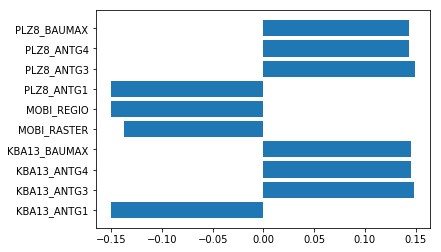

In [9]:
pca_detail(pca10,azdias_final.columns)

PCA Dimension 1 :


,0,1,2,3,4,5,6,7,8,9
features,KBA13_HERST_BMW_BENZ,KBA13_SEG_OBEREMITTELKLASSE,KBA13_MERCEDES,KBA13_BMW,KBA13_SITZE_5,KBA13_SITZE_4,KBA13_SEG_SPORTWAGEN,KBA05_HERST1,KBA13_SEG_KLEINWAGEN,KBA13_KMH_140_210
weights,0.183066,0.157324,0.156823,0.152312,-0.151553,0.146998,0.140542,0.131073,-0.130915,-0.129123


<Container object of 10 artists>

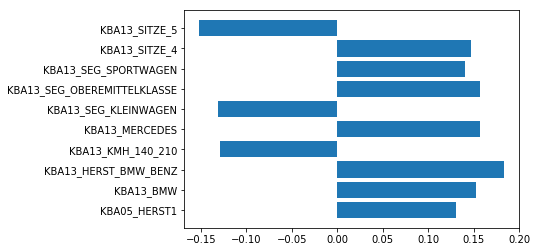

In [10]:
pca_detail(pca10,azdias_final.columns,1)

PCA Dimension 2 :


,0,1,2,3,4,5,6,7,8,9
features,CJT_TYP_1,FINANZ_SPARER,CJT_TYP_2,FINANZ_VORSORGER,CJT_TYP_5,ALTERSKATEGORIE_GROB,CJT_TYP_4,FINANZ_UNAUFFAELLIGER,FINANZ_ANLEGER,SEMIO_PFLICHT
weights,-0.20586,-0.201003,-0.199343,0.189538,0.188039,0.183803,0.182592,-0.181018,-0.179354,-0.178292


<Container object of 10 artists>

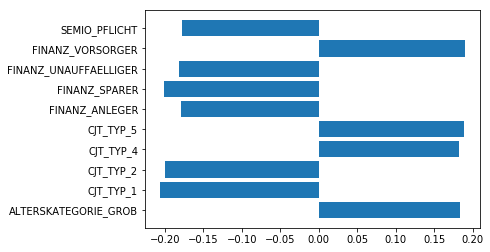

In [11]:
pca_detail(pca10,azdias_final.columns,2)

In [12]:
batch_size = int(len(azdias_scaled_pca)*.01)
print(batch_size)

scores = []
for i in range(45):
    km = MiniBatchKMeans(n_clusters = i+1, batch_size = batch_size)
    km.fit(azdias_scaled_pca)
    
    scores.append(np.abs(km.score(azdias_scaled_pca)))
    print(i,km.score(azdias_scaled_pca))

7324
0 -131793120.372
1 -117953016.246
2 -112788681.115
3 -108158806.926
4 -105069326.789
5 -102369583.293
6 -100329008.074
7 -98448216.8899
8 -97067157.501
9 -95188905.2459
10 -94910136.174
11 -93211963.2175
12 -92471658.2205
13 -92103860.9423
14 -91003512.3971
15 -90790010.4207
16 -89942320.4941
17 -89446330.1199
18 -88336630.6412
19 -88495070.2328
20 -87987366.3811
21 -87549132.9644
22 -87105661.6902
23 -86304517.8167
24 -86379912.6522
25 -86793230.053
26 -85791045.3522
27 -85524868.0492
28 -84818382.5091
29 -84856184.1568
30 -84059150.4212
31 -83881023.3684
32 -84086622.4304
33 -83511596.9808
34 -83335172.0651
35 -83139252.4123
36 -83241863.0085
37 -81901087.7708
38 -82043428.6573
39 -82036358.892
40 -82169290.734
41 -81921189.0382
42 -81024987.85
43 -81364910.0957
44 -80662268.1332


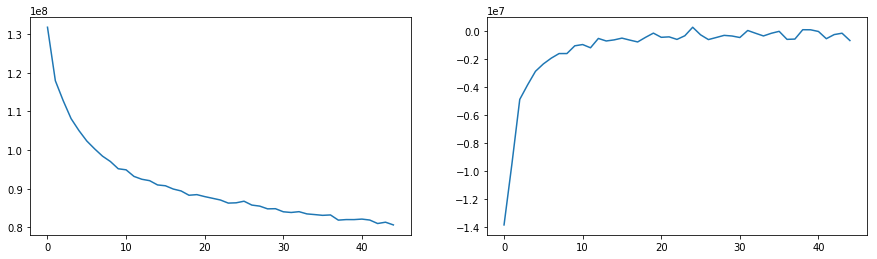

In [13]:
f,ax = plt.subplots(figsize=(15,4))

ax = plt.subplot(1,2,1)
plt.plot(scores)

ax = plt.subplot(1,2,2)
plt.plot(np.gradient(scores))

In [14]:
km = KMeans(n_clusters = 10, random_state = 42)
km.fit(azdias_scaled_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [15]:
azdias_final.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1.057824,1.259660,1.640855,0.186281,-0.125912,-0.298834,0.225714,0.334745,-0.060503,-0.179682,...,-0.408368,0.44202,-0.295946,-0.205912,-0.448799,-0.658734,-0.601416,1.891895,-0.907900,0.995154
1,1.057843,1.259660,0.747417,0.120125,-0.125912,-0.298834,-0.633709,-0.032349,-0.060503,-0.179682,...,-0.408368,0.44202,-0.295946,-0.205912,-0.448799,-0.658734,1.662743,-0.528571,1.101443,-1.004870
2,1.057847,-0.936021,-0.146022,-0.475279,-0.125912,-0.298834,-1.493132,-0.399444,-0.060503,-1.185459,...,-0.408368,0.44202,-0.295946,-0.205912,-0.448799,1.518064,-0.601416,-0.528571,1.101443,-1.004870
3,1.057905,-0.936021,0.077338,-0.342967,-0.125912,-0.298834,1.944561,-0.326025,-0.060503,0.826095,...,-0.408368,0.44202,-0.295946,-0.205912,-0.448799,-0.658734,1.662743,-0.528571,-0.907900,0.995154
4,1.057917,-0.936021,-0.816101,-0.210655,-0.125912,-0.298834,-0.633709,-0.399444,-0.060503,-1.185459,...,-0.408368,0.44202,-0.295946,-0.205912,2.228169,-0.658734,-0.601416,-0.528571,-0.907900,0.995154


In [16]:
scaler = StandardScaler()

In [17]:
def cluster_predict(df0,pca,km):
    df = pd.DataFrame(data=df0, index=df0.index, columns=df0.columns)
    df = pca.transform(df)
    df0['cluster'] = km.predict(df)
    return df0

In [18]:
azdias_final.shape

(732440, 364)

In [19]:
df_azdias = cluster_predict(azdias_final,pca10,km)

In [20]:
df_azdias.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,cluster
0,1.057824,1.259660,1.640855,0.186281,-0.125912,-0.298834,0.225714,0.334745,-0.060503,-0.179682,...,0.44202,-0.295946,-0.205912,-0.448799,-0.658734,-0.601416,1.891895,-0.907900,0.995154,0
1,1.057843,1.259660,0.747417,0.120125,-0.125912,-0.298834,-0.633709,-0.032349,-0.060503,-0.179682,...,0.44202,-0.295946,-0.205912,-0.448799,-0.658734,1.662743,-0.528571,1.101443,-1.004870,0
2,1.057847,-0.936021,-0.146022,-0.475279,-0.125912,-0.298834,-1.493132,-0.399444,-0.060503,-1.185459,...,0.44202,-0.295946,-0.205912,-0.448799,1.518064,-0.601416,-0.528571,1.101443,-1.004870,8
3,1.057905,-0.936021,0.077338,-0.342967,-0.125912,-0.298834,1.944561,-0.326025,-0.060503,0.826095,...,0.44202,-0.295946,-0.205912,-0.448799,-0.658734,1.662743,-0.528571,-0.907900,0.995154,2
4,1.057917,-0.936021,-0.816101,-0.210655,-0.125912,-0.298834,-0.633709,-0.399444,-0.060503,-1.185459,...,0.44202,-0.295946,-0.205912,2.228169,-0.658734,-0.601416,-0.528571,-0.907900,0.995154,0


In [21]:
df_customers=cluster_predict(customers_final,pca10,km)

In [22]:
#df_customers=customers_final

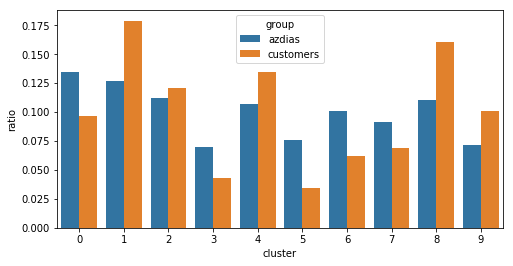

In [23]:
f,ax = plt.subplots(figsize=(8,4))
dfa = pd.DataFrame()
dfa['ratio'] = df_azdias.groupby('cluster').size()/len(df_azdias)
dfa['group'] = 'azdias'
dfa = dfa.reset_index()

dfc = pd.DataFrame()
dfc['ratio'] = df_customers.groupby('cluster').size()/len(df_customers)
dfc['group'] = 'customers'
dfc = dfc.reset_index()

dft = pd.concat([dfa,dfc])
sns.barplot(x='cluster',y='ratio',hue='group',data=dft,ax=ax)

In [1]:
km.cluster_centers_[1]

NameError: name 'km' is not defined

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [115]:
train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [116]:
train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [118]:
train = train.merge(customers[['LNR','CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']],how='left',on='LNR')
train.shape

(42962, 370)

In [120]:
train = clean_data(train, unknowns)

In [121]:
df_train=train

In [123]:
df_train['CUSTOMER_GROUP'].head()

0    MULTI_BUYER
1    MULTI_BUYER
2    MULTI_BUYER
3    MULTI_BUYER
4    MULTI_BUYER
Name: CUSTOMER_GROUP, dtype: category
Categories (2, object): [MULTI_BUYER, SINGLE_BUYER]

In [124]:
df_train['CUSTOMER_GROUP'] = df_train['CUSTOMER_GROUP'].apply(lambda x:1 if x=='SINGLE_BUYER' else 0)
df_train['PRODUCT_GROUP1'] = df_train['PRODUCT_GROUP'].apply(lambda x:1 if 'FOOD' in x else 0)
df_train['PRODUCT_GROUP2'] = df_train['PRODUCT_GROUP'].apply(lambda x:1 if 'COSMETIC' in x else 0)
df_train = df_train.drop(['PRODUCT_GROUP'],axis=1)

In [125]:
# Define the labels (y) to be the response column, and the rest of the columns to be X
y = df_train['RESPONSE']
del df_train['RESPONSE']
X = df_train
y.shape, X.shape

((42962,), (42962, 372))

In [126]:
# Obtain the vale counts for the response column
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [127]:
# The imputer does not work at this stage because the columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 
# have values that strings "X" and "XX".  EINGEFUEGT_AM has a similar issue. Remove these columns 
# for simplicity.  
del X['D19_LETZTER_KAUF_BRANCHE']
del X['D19_LOTTO']
del X['EINGEFUEGT_AM']
del X['CAMEO_DEUG_2015']
del X['CAMEO_INTL_2015']

# Perform imputation on train df
imputer = Imputer()
X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
X.head()


,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRODUCT_GROUP1,PRODUCT_GROUP2
0,1763.0,1.0,8.0,15.0,0.000000,0.0,1.0,13.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
1,1771.0,4.0,13.0,1.0,0.000000,0.0,2.0,1.0,0.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2,1776.0,1.0,7.0,0.0,0.049574,0.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,1460.0,1.0,6.0,4.0,0.000000,0.0,2.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,1783.0,1.0,9.0,53.0,0.000000,0.0,1.0,44.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0


In [128]:
# Apply feature scaling to the train df
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRODUCT_GROUP1,PRODUCT_GROUP2
0,-1.656309,-0.329514,-0.471237,0.604874,-0.145,-0.245521,-0.818214,0.518647,-0.10013,-0.048327,...,-0.130555,-0.108733,-0.404226,-0.525800,-0.419113,1.453138,-0.871293,1.234287,0.540418,0.576472
1,-1.655987,1.552561,0.798904,-0.416145,-0.145,-0.245521,-0.013746,-0.406937,-0.10013,-1.117178,...,7.659598,-0.108733,-0.404226,-0.525800,2.385989,-0.688166,1.147719,-0.810184,0.540418,0.576472
2,-1.655785,-0.329514,-0.725266,-0.489075,0.000,-0.245521,-1.622682,-0.406937,-0.10013,1.020523,...,-0.130555,-0.108733,-0.404226,-0.525800,-0.419113,1.453138,1.147719,-0.810184,0.540418,0.576472
3,-1.668538,-0.329514,-0.979294,-0.197355,-0.145,-0.245521,-0.013746,-0.175541,-0.10013,1.020523,...,-0.130555,-0.108733,-0.404226,1.901864,-0.419113,-0.688166,-0.871293,1.234287,0.540418,0.576472
4,-1.655502,-0.329514,-0.217209,3.376210,-0.145,-0.245521,-0.818214,2.909739,-0.10013,-0.048327,...,-0.130555,-0.108733,-0.404226,1.901864,-0.419113,-0.688166,1.147719,-0.810184,0.540418,0.576472


In [186]:
test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [187]:
test.shape

(42833, 366)

In [188]:
test = test.merge(customers[['LNR','CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']],how='left',on='LNR')
test.shape

(42833, 369)

In [189]:
test = clean_data(test, unknowns)

In [190]:
test.shape

(42833, 371)

In [156]:
#df_test=test

In [195]:
test.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRODUCT_GROUP1,PRODUCT_GROUP2
0,1754,1.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,0,0,0,0,0,1,1,0,1,1
1,1770,1.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,...,0,0,0,0,1,0,1,0,1,0
2,1465,9.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,...,0,0,0,0,0,1,1,0,0,1
3,1470,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0,0,0,0,0,1,0,1,0,1
4,1478,1.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,...,0,0,0,0,0,1,1,0,1,1


In [193]:
#test['CUSTOMER_GROUP']

In [194]:

test['CUSTOMER_GROUP'] = test['CUSTOMER_GROUP'].apply(lambda x:1 if x=='SINGLE_BUYER' else 0)
test['PRODUCT_GROUP1'] = test['PRODUCT_GROUP'].apply(lambda x:1 if 'FOOD' in x else 0)
test['PRODUCT_GROUP2'] = test['PRODUCT_GROUP'].apply(lambda x:1 if 'COSMETIC' in x else 0)



In [196]:
test = test.drop(['PRODUCT_GROUP'],axis=1)

In [197]:
test.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRODUCT_GROUP1,PRODUCT_GROUP2
0,1754,1.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,0,0,0,0,0,1,1,0,1,1
1,1770,1.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,...,0,0,0,0,1,0,1,0,1,0
2,1465,9.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,...,0,0,0,0,0,1,1,0,0,1
3,1470,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0,0,0,0,0,1,0,1,0,1
4,1478,1.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,...,0,0,0,0,0,1,1,0,1,1


In [160]:
#df_test

In [198]:

# Copy LNR column for later when generating Kaggle submission csv 
test_LNR = test['LNR']

In [199]:
test.shape

(42833, 372)

In [200]:
del test['D19_LETZTER_KAUF_BRANCHE']
del test['D19_LOTTO']
del test['EINGEFUEGT_AM']
del test['CAMEO_DEUG_2015']
del test['CAMEO_INTL_2015']

# Perform imputation on train df
imputer = Imputer()
test = pd.DataFrame(imputer.fit_transform(test), columns = test.columns)
test.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRODUCT_GROUP1,PRODUCT_GROUP2
0,1754.0,1.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,1770.0,1.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1465.0,9.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1470.0,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1478.0,1.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


In [201]:
scaler = StandardScaler()
test = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)
test.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,PRODUCT_GROUP1,PRODUCT_GROUP2
0,-1.665871,-0.326023,-0.962638,-0.353063,-0.149514,-0.247607,-0.018874,-0.340189,-0.105655,-0.041983,...,-0.131216,-0.108789,-0.407197,-0.521563,-0.425916,1.460445,1.147628,-0.811811,0.540892,0.573639
1,-1.665225,-0.326023,-2.473613,0.984863,-0.149514,-0.247607,-0.822656,1.151929,-0.105655,1.016662,...,-0.131216,-0.108789,-0.407197,-0.521563,2.347881,-0.684723,1.147628,-0.811811,0.540892,-1.743257
2,-1.677546,4.700435,0.296508,-0.353063,-0.149514,-0.247607,1.588691,-0.340189,-0.105655,1.016662,...,-0.131216,-0.108789,-0.407197,-0.521563,-0.425916,1.460445,1.147628,-0.811811,-1.848797,0.573639
3,-1.677344,3.443821,-2.473613,-0.427392,-0.149514,-0.247607,-1.626438,-0.418721,-0.105655,1.016662,...,-0.131216,-0.108789,-0.407197,-0.521563,-0.425916,1.460445,-0.871362,1.231815,-1.848797,0.573639
4,-1.677021,-0.326023,0.800166,-0.427392,-0.149514,-0.247607,1.588691,-0.418721,-0.105655,-0.041983,...,-0.131216,-0.108789,-0.407197,-0.521563,-0.425916,1.460445,1.147628,-0.811811,0.540892,0.573639


In [167]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter
from operator import itemgetter
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [168]:
def classifier_roc(clf, param_grid, X=X, y=y):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    
    start = time.time()
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    end = time.time()
    print(end-start)

    print(grid.best_score_)
    
    return grid.best_estimator_

In [52]:
# LogisticRegression

logreg = LogisticRegression()
print(classifier_roc(logreg, {}))

89.90135979652405
0.680073011803
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [53]:
# GradientBoostingClassifier

gbc = GradientBoostingClassifier()
print(classifier_roc(gbc, {}))

225.72905898094177
0.774867841358
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [54]:
# AdaBoostClassifier

ada = AdaBoostClassifier()
print(classifier_roc(ada, {}))

75.50255012512207
0.763610000815
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


In [34]:
# Optimize the AdaBoostClassifier using GridSearchCV

start = time.time()

param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.01, 0.1, 1.0],
             'n_estimators': [20, 50, 100]}

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

end = time.time()
cv_time = end - start
cv_time

0.774913318908
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)


627.1453313827515

In [169]:
# Rerun AdaBoostClassifier with optimized parameters
param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.1],
             'n_estimators': [50]}

best_model = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
best_model.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'algorithm': ['SAMME.R'], 'learning_rate': [0.1], 'n_estimators': [50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [202]:
# Calculate prediction probabilities for the test set and print the first 10 results
preds = best_model.predict_proba(test)
preds[:10]

array([[ 0.67052209,  0.32947791],
       [ 0.67052209,  0.32947791],
       [ 0.74982702,  0.25017298],
       [ 0.75188621,  0.24811379],
       [ 0.75068264,  0.24931736],
       [ 0.7523784 ,  0.2476216 ],
       [ 0.75379553,  0.24620447],
       [ 0.67052209,  0.32947791],
       [ 0.67353012,  0.32646988],
       [ 0.74337689,  0.25662311]])

In [203]:
# Generate a csv file to be submitted to Kaggle with the LNR id and prediction of response as columns.
# Use second column of the array as the probabilities to be entered (probability of a positive response).
# Print the first few lines of the kaggle dataframe.
kaggle = pd.DataFrame({'LNR':test_LNR.astype(np.int32), 'RESPONSE':preds[:, 1]})
kaggle.to_csv('kaggle2.csv', index = False)
kaggle.head()

,LNR,RESPONSE
0,1754,0.329478
1,1770,0.329478
2,1465,0.250173
3,1470,0.248114
4,1478,0.249317


In [69]:
kaggle.shape

(42833, 2)

In [75]:
# # Optimize the GBCLassifier using GridSearchCV

In [77]:

gbc = GradientBoostingClassifier()
print(classifier_roc(gbc, param_grid = {
             'learning_rate': [0.01, 0.1, 1.0],
             'n_estimators': [20, 50, 100,200]}))

2060.0535867214203
0.777618275948
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [206]:
param_grid = {
             'learning_rate': [0.01],
             'n_estimators': [200]}

best_model1 = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
best_model1.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01], 'n_estimators': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [207]:
preds1 = best_model1.predict_proba(test)
preds1[:10]

array([[ 0.9718241 ,  0.0281759 ],
       [ 0.97165606,  0.02834394],
       [ 0.99478946,  0.00521054],
       [ 0.9946266 ,  0.0053734 ],
       [ 0.99518933,  0.00481067],
       [ 0.99537132,  0.00462868],
       [ 0.99492972,  0.00507028],
       [ 0.97786667,  0.02213333],
       [ 0.97754911,  0.02245089],
       [ 0.99486617,  0.00513383]])

In [209]:
# Generate a csv file to be submitted to Kaggle with the LNR id and prediction of response as columns.
# Use second column of the array as the probabilities to be entered (probability of a positive response).
# Print the first few lines of the kaggle dataframe.
kaggle = pd.DataFrame({'LNR':test_LNR.astype(np.int32), 'RESPONSE':preds1[:, 1]})
kaggle.to_csv('kaggle3.csv', index = False)
kaggle.head()

,LNR,RESPONSE
0,1754,0.028176
1,1770,0.028344
2,1465,0.005211
3,1470,0.005373
4,1478,0.004811


In [205]:
# analyse the most important features of the model
fi = pd.DataFrame({'FI':best_model.best_estimator_.feature_importances_}, index=df_train.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted.head(10)

,FI
D19_SOZIALES,0.86
EINGEZOGENAM_HH_JAHR,0.04
RT_SCHNAEPPCHEN,0.04
KBA05_SEG2,0.02
KBA05_ANHANG,0.02
D19_KONSUMTYP_MAX,0.02
LNR,0.00
KONSUMZELLE,0.00
KONSUMNAEHE,0.00
KOMBIALTER,0.00


In [210]:
# analyse the most important features of the model
fi = pd.DataFrame({'FI':best_model1.best_estimator_.feature_importances_}, index=df_train.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted.head(10)

,FI
D19_SOZIALES,0.453943
ANZ_KINDER,0.076725
EINGEZOGENAM_HH_JAHR,0.044215
D19_KONSUMTYP,0.042881
GEBAEUDETYP_6.0,0.040884
KBA05_HERST3,0.030278
LP_FAMILIE_GROB_1.0,0.018358
VHA,0.018019
D19_TELKO_ONLINE_QUOTE_12,0.017746
KBA05_SEG2,0.015467


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')